In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import warnings
import time
import random
warnings.filterwarnings('ignore')

In [9]:
data = pd.read_excel(r"C:\Users\saif\Desktop\PFE\JupyterNoteBook\contact_history_multiple.xlsx", engine="openpyxl")
data['EventDate'] = pd.to_datetime(data['EventDate'], format='%Y-%m-%d %H:%M:%S')
data['day_of_week'] = data['EventDate'].dt.day_name()

In [58]:

'''So here we convert the set time into minutes and the other way around and we calculate the time spent for receiving or engaging compared to the hour range''' 
def sent_date_to_min(sent_time):
    ''' Given the sent datetime, return the total minutes since midnight. '''
    return sent_time.hour * 60 + sent_time.minute

def from_min_to_hour_and_min(mins):
    '''Given the total minutes, return a formatted string representing hours and minutes.'''
    hours = int(round(mins)) // 60
    minutes = int(round(mins)) % 60
    return "{}:{}".format(hours, minutes)

def exp_decay_fit(x, sent_engaged_hour_range):
    '''Return a value from 0 to 1 following an exponential decreasing function.
       This represents the probability of engagement decreasing over time.'''
    if x > sent_engaged_hour_range * 60:
        return 0.0  # If engagement is beyond the defined time range, probability is zero
    if x < 0:
        return 1  # If engagement is instant, probability is highest
    return math.exp(15 * ((-math.log(2) / (sent_engaged_hour_range * 60)) * x) + math.log(2)) / 2
#print (exp_decay_fit(10,5))


def compute_fitSA(hash_mex, hash_contact, sent_engage_hour_range, data):
    '''Given the hash message, the hash contact, and the dataset, return the fitSA 
    for that hash message and hash contact in an SMS campaign.'''
    '''we create 2 arrays'''
    sents, received = [], []
    list_index = get_all_indexes(hash_mex, hash_contact, data) 
    '''array contains all the indexes of the hashmessage and HashContact''' 
    for i in list_index:
        ''' thot row mtaa el index i (date w name) f des varibales bech tekhdem behom baed ala hasb valeur mtaa les varibales 
        baed thothom f wahda mel arrays  , sents reveived w engaged'''
        event_type = data['EventName'].iloc[i]  # Use .iloc[i] for proper indexing
        event_time = data["EventDate"].iloc[i]
        
        if event_type == 'Sent':
            sents.append(event_time)
        elif event_type == 'Received':
            received.append(event_time)
    if not sents:
        return 0.0, None  # Safeguard: There must be a 'Sent' event
    sent_time = sent_date_to_min(sents[0])  # Convert sent time to minutes
    # Find the earliest event after 'Sent': first Received, then Engaged
    first_event = None
    if received:
        first_event = min(received)  # First time the SMS was received
    '''tekhou awel event''' 
    # If no engagement happens, return 0
    if first_event is None:
        return 0.0, sent_time  
    # Compute the time difference between Sent and First Engagement
    mins = (first_event - sents[0]).total_seconds() / 60  # Convert to minutes
    return exp_decay_fit(mins, sent_engage_hour_range), sent_time


''' here it's the same but we're calculating the difference between the received and engaged'''
def compute_fitAC(hash_mex, hash_contact, received_engaged_hour_range, data):
    '''Given the hash message, the hash contact, and the dataset, return the fitAC
    for that hash message and hash contact in an SMS campaign.'''
    received, engaged = [], []
    list_index = get_all_indexes(hash_mex, hash_contact, data)
    for i in list_index:
        event_type = data['EventName'].iloc[i]  # Correct indexing
        event_time = data["EventDate"].iloc[i]
        if event_type == 'Received':
            received.append(event_time)
        elif event_type == 'Engaged':
            engaged.append(event_time) 
    oldest_received = None
    oldest_engaged = None
    # Case: Message engaged but "Received" event not detected
    if not received and engaged:
        return -1  
    # Case: No engagement at all
    if not engaged:
        return 0.0    
    # Find the first Received and first Engaged event
    if received:
        oldest_received = min(received)
    if engaged:
        oldest_engaged = min(engaged)
    # Compute time difference in minutes between Received and Engaged
    mins = (oldest_engaged - oldest_received).total_seconds() / 60  
    return exp_decay_fit(mins, received_engaged_hour_range)


def received_rate_mex_time_slot(hash_contact, data):
    '''Given a hash contact and the raw data, return the received rate for that contact for each
    hour (from 0 to 24).'''
    mex_plus_contact_distinct = []
    dates = []
    # Get all indexes where the contact appears
    list_index = data.index[data["HashContact"] == hash_contact].tolist()
    for i in list_index:
        if pd.notna(data["EventDate"][i]) and data["EventName"][i] == 'Received' and \
           (data["HashMessage"][i] + data['HashContact'][i]) not in mex_plus_contact_distinct:
            mex_plus_contact_distinct.append(data["HashMessage"][i] + data['HashContact'][i])
            dates.append(pd.to_datetime(data["EventDate"][i]))
    tot_mex_received = len(mex_plus_contact_distinct) 
    if len(dates) == 0:  # The user has never received messages
        return np.zeros((24,))
    df = pd.DataFrame(dates, columns=['dates'])
    df = df.assign(session=pd.cut(df["dates"].dt.hour,
                                  range(25),
                                  labels=[f"{i}-{i+1}" for i in range(24)],
                                  include_lowest=True))
    numpy_output = df['session'].value_counts().sort_index().to_numpy() / tot_mex_received
    return numpy_output
def dp_received_rate_mex_time_slot(data):
    '''Given the raw data, return a dictionary that represents for each contact
    their received rate.'''
    d = {i: None for i in data["HashContact"].unique()}
    for key in d:
        d[key] = received_rate_mex_time_slot(key, data)
    return d



def engaged_rate_mex_time_slot(hash_contact, data):
    '''Given a hash contact and the raw data, return the engaged rate for that contact for each
    hour (from 0 to 24).'''
    mex_plus_contact_distinct = []
    dates = []
    # Get all indexes where the contact appears
    list_index = data.index[data["HashContact"] == hash_contact].tolist()
    for i in list_index:
        if pd.notna(data["EventDate"][i]) and data["EventName"][i] == 'Engaged' and \
           (data["HashMessage"][i] + data['HashContact'][i]) not in mex_plus_contact_distinct:
            mex_plus_contact_distinct.append(data["HashMessage"][i] + data['HashContact'][i])
            dates.append(pd.to_datetime(data["EventDate"][i]))
    tot_mex_engaged = len(mex_plus_contact_distinct) 
    if len(dates) == 0:  # The user has never engaged with messages
        return np.zeros((24,))
    df = pd.DataFrame(dates, columns=['dates'])
    
    df = df.assign(session=pd.cut(df["dates"].dt.hour,
                                  range(25),
                                  labels=[f"{i}-{i+1}" for i in range(24)],
                                  include_lowest=True))
    numpy_output = df['session'].value_counts().sort_index().to_numpy() / tot_mex_engaged
    return numpy_output
def dp_engaged_rate_mex_time_slot(data):
    '''Given the raw data, return a dictionary that represents for each contact
    their engaged rate.'''
    d = {i: None for i in data["HashContact"].unique()}
    for key in d:
        d[key] = engaged_rate_mex_time_slot(key, data)
    return d


def rate_sms_time_slote(data, event_type):
    ''' 
    "event_type" can be either "Received" or "Engaged".
    Returns scatter plot of event ratios per hour slot (0-24).
    ''' 
    if event_type not in ['Received', 'Engaged']:
        raise ValueError("event_type must be either 'Received' or 'Engaged'")   
    sms_stats = {}
    data['EventDate'] = pd.to_datetime(data['EventDate'])

    # Create hour bins and labels
    hour_bins = [f"{i}-{i+1}" for i in range(24)]
    x_positions = np.arange(24) + 0.5  # Center points between hour numbers
    # Initialize structure
    for campaign in data["CommunicationName"].unique():
        sms_stats[campaign] = {
            'total_events': 0,
            'timestamps': [],
            'time_slot_distribution': np.zeros(24)
        }
    # Collect data
    for campaign in data['CommunicationName'].unique():
        unique_combos = set()
        campaign_data = data[data['CommunicationName'] == campaign]    
        for _, row in campaign_data.iterrows():
            if row['EventName'] == event_type:
                combo = row['HashMessage'] + row['HashContact']
                if combo not in unique_combos:
                    unique_combos.add(combo)
                    sms_stats[campaign]['timestamps'].append(row['EventDate'])
                    sms_stats[campaign]['total_events'] += 1
    # Calculate ratios and plot
    for campaign, stats in sms_stats.items():
        if stats['total_events'] == 0:
            continue        
        # Calculate hourly distribution
        hours = [ts.hour for ts in stats['timestamps']]
        counts, _ = np.histogram(hours, bins=np.arange(25))
        ratios = counts / stats['total_events']
        # Store ratios'''
        sms_stats[campaign]['time_slot_distribution'] = ratios
    return sms_stats
#print(rate_sms_time_slote(data, "Engaged"))


def compute_sms_fitSA(hash_msg, hash_contact, sent_engaged_hour_range, data, sent_pred):
    """
    FitSA Evaluation Compared to the real time sentHour -sent-received
    """
    # Convert sent_pred to datetime format
    hours = int(sent_pred // 60)
    minutes = int(sent_pred % 60)
    sent_pred = f"{hours:02d}:{minutes:02d}"  # Format as HH:MM
    sent_pred = pd.to_datetime(sent_pred, format='%H:%M')



    # Filter data for the given message and contact
    df2 = data[data['HashMessage'] == hash_msg]
    df3 = df2[df2['HashContact'] == hash_contact]
    
    # Get 'Received' event
    df4 = df3[df3['EventName'] == 'Received']
    received_times = list(df4['EventDate'])

    # Find the earliest event (received or engaged)
    earliest_event = None
    for time in received_times:
        if earliest_event is None or time < earliest_event:
            earliest_event = time
    #print(f"earliest event : {earliest_event}")
    #print(f"sent time : {sent_pred}")
    # If the SMS was never received or engaged, return 0
    if earliest_event is None:
        return 0.0
    if earliest_event < sent_pred :
        print("sent can't be after receive or enagaged")
        return 0.0
    # Compute minutes elapsed from sent time to first interaction
    minutes_elapsed = (sent_date_to_min(earliest_event) - sent_date_to_min(sent_pred))
    #print(minutes_elapsed)
    # Compute fitness score using the provided exponential decay function
    return exp_decay_fit(minutes_elapsed, sent_engaged_hour_range)

def compute_sms_fitAC(hash_msg, hash_contact, sent_engaged_hour_range, data, sent_pred):
    """
    FitSA Evaluation Compared to the real time sentHour -sent-engaged
    """
    hours = int(sent_pred // 60)
    minutes = int(sent_pred % 60)
    sent_pred = f"{hours:02d}:{minutes:02d}"  # Format as HH:MM
    sent_pred = pd.to_datetime(sent_pred, format='%H:%M')
    # Filter data for the given message and contact
    df2 = data[data['HashMessage'] == hash_msg]
    df3 = df2[df2['HashContact'] == hash_contact]
    df5 = df3[df3['EventName'] == 'Engaged']
    engaged_times = list(df5['EventDate'])

    # Find the earliest event (received or engaged)
    earliest_event = None
    for time in engaged_times:
        if earliest_event is None or time < earliest_event:
            earliest_event = time
    #print(f"earliest event : {earliest_event}")
    #print(f"sent time : {sent_pred}")
    # If the SMS was never received or engaged, return 0
    if earliest_event is None:
        return 0.0
    if earliest_event < sent_pred :
        print("sent can't be after receive or enagaged")
        return 0.0
    minutes_elapsed = (sent_date_to_min(earliest_event) - sent_date_to_min(sent_pred))
   # print(minutes_elapsed)
    # Compute fitness score using the provided exponential decay function
    return exp_decay_fit(minutes_elapsed, sent_engaged_hour_range)

def evaluate(df, X, data, sent_open_hour_range, preds):
    '''Given the prediction of the model "preds" returns:
    - how many fitSA are better than the ground truth fitSA
    - how many fitSA are equal than the ground truth fitSA
    - how many fitSA are worse than the ground truth fitSA.
    '''
    # from [0, 1] to mins
    for i in range(len(preds)):
        preds[i] *= 24*60 # this 24*60 is requierd to convert mins from [0, 1] into real mins
    # get fitSA using the predicted sent
    fitSA_preds = []
    fitSC_preds = []
    for i in range(len(df)):
        fitSA_preds.append(compute_sms_fitSA(df['HashMessage'][i], df['HashContact'][i], sent_open_hour_range, data, preds[i]))
        fitSC_preds.append(compute_sms_fitAC(df['HashMessage'][i], df['HashContact'][i], sent_open_hour_range, data, preds[i]))
    
    total_mex = len(fitSA_preds)
    predicted_sent_better_usual_sent = 0
    predicted_sent_equal_usual_sent = 0
    predicted_sent_worst_usual_sent = 0
    for i in range(total_mex):
        if fitSA_preds[i] > X.loc[i, 'fitSA']: # new position of fitSA
            predicted_sent_better_usual_sent += 1
        elif fitSA_preds[i] == X.loc[i, 'fitSA']:
            predicted_sent_equal_usual_sent += 1
        elif fitSC_preds[i] > X.loc[i, 'fitAC']: # new position of fitAC
            predicted_sent_better_usual_sent += 1
        elif fitSC_preds[i] == X.loc[i, 'fitAC']:
            predicted_sent_equal_usual_sent += 1
        else:
            predicted_sent_worst_usual_sent += 1 # case fitSC predetta < fitAC reale
    return predicted_sent_better_usual_sent/total_mex, predicted_sent_equal_usual_sent/total_mex, predicted_sent_worst_usual_sent/total_mex


def split_train_test_by_lifetime(X, df, data, test_size, random_seed):
    d7 = {}
    for i in data["HashContact"].unique():
        if i not in d7:
            d7[i] = []
    for i in range(len(data)):
        if "nan" not in str(data["EventDate"][i]) and (str(data["EventName"][i]) == 'Received' or str(data["EventName"][i]) == 'Engaged'):
            d7[data["HashContact"][i]].append(data["EventDate"][i])
    # Here I merge in the same category (assign 0 days) who never opened with the users that opened just once
    for i in data["HashContact"].unique():
        if len(d7[i]) == 0 or len(d7[i]) == 1:
            d7[i] = 0 # 0 days as lifetime
        else:
        # retain newest and oldest date
            newest_date = d7[i][0] # get the first date
            oldest_date = d7[i][0] # get the first date
            for j in d7[i]:
                if j > newest_date:
                    newest_date = j
                if j < oldest_date:
                    oldest_date = j
            # assign the lifetitme for the contact i
            d7[i] = (newest_date - oldest_date).days
    df['Lifetime'] = 0
    for i in range(len(df)):
        df.loc[i, 'Lifetime'] = d7[df['HashContact'][i]]
    lt = df['Lifetime'].to_numpy()
    zero = []
    today = []
    between = []
    for i in range(len(lt)):
        if lt[i] == 0:
            zero.append(i)
        elif lt[i] >= 320: # TODO: here I assume that a user still open today whether his lifetime is greater than or equal than 320 (it means that the last time he opened is 1 month ago)
            today.append(i)
        else:
            between.append(i)
            
    random.Random(random_seed).shuffle(zero) # 39%
    random.Random(random_seed).shuffle(today) # 17%
    random.Random(random_seed).shuffle(between) # 43%
    
    percentage_zero_train = round(len(zero) - (test_size * len(zero)))
    percentage_today_train = round(len(today) - (test_size * len(today)))
    percentage_between_train = round(len(between) - (test_size * len(between)))
    
    train_indexes_zero = zero[:percentage_zero_train]
    test_indexes_zero = zero[percentage_zero_train:]

    train_indexes_today = today[:percentage_today_train]
    test_indexes_today = today[percentage_today_train:]

    train_indexes_between = between[:percentage_between_train]
    test_indexes_between = between[percentage_between_train:]
    
    X_train = X.iloc[train_indexes_zero + train_indexes_today + train_indexes_between, :]
    y_train = df.iloc[train_indexes_zero + train_indexes_today + train_indexes_between, :]['Label']
    X_test = X.iloc[test_indexes_zero + test_indexes_today + test_indexes_between, :]
    y_test = df.iloc[test_indexes_zero + test_indexes_today + test_indexes_between, :]['Label']
    
    df_train = df.iloc[train_indexes_zero + train_indexes_today + train_indexes_between, :]
    df_test = df.iloc[test_indexes_zero + test_indexes_today + test_indexes_between, :]
    return X_train, X_test, y_train, y_test, df_train, df_test

    
def avg_for_new_contact(X):
    '''For a new contact, the average of the open rate, click rate, open rate for communication
    , click rate for communication need to be assigned to it. Given all the processed dataset X,
    return these averages.'''
    received_rate_avg = X[["RR0-1", "RR1-2", "RR2-3", "RR3-4", "RR4-5", "RR5-6", "RR6-7", "RR7-8", "RR8-9", "RR9-10", "RR10-11", "RR11-12",
"RR12-13", "RR13-14", "RR14-15", "RR15-16", "RR16-17", "RR17-18", "RR18-19", "RR19-20", "RR20-21", "RR21-22", "RR22-23", "RR23-24"]].mean()

    engaged_rate_avg = X[["ER0-1", "ER1-2", "ER2-3", "ER3-4", "ER4-5", "ER5-6", "ER6-7", "ER7-8", "ER8-9", "ER9-10", "ER10-11", "ER11-12",
"ER12-13", "ER13-14", "ER14-15", "ER15-16", "ER16-17", "ER17-18", "ER18-19", "ER19-20", "ER20-21", "ER21-22", "ER22-23", "ER23-24"]].mean()

    received_rate_comm = X[["RR-C 0-1", "RR-C 1-2", "RR-C 2-3", "RR-C 3-4", "RR-C 4-5", "RR-C 5-6", "RR-C 6-7", "RR-C 7-8", "RR-C 8-9", "RR-C 9-10", "RR-C 10-11", "RR-C 11-12", 
"RR-C 12-13", "RR-C 13-14", "RR-C 14-15", "RR-C 15-16", "RR-C 16-17", "RR-C 17-18", "RR-C 18-19", "RR-C 19-20", "RR-C 20-21", "RR-C 21-22", "RR-C 22-23", "RR-C 23-24"]].mean()

    engaged_rate_comm = X[["ER-C 0-1", "ER-C 1-2", "ER-C 2-3", "ER-C 3-4", "ER-C 4-5", "ER-C 5-6", "ER-C 6-7", "ER-C 7-8", "ER-C 8-9", "ER-C 9-10", "ER-C 10-11", "ER-C 11-12", 
"ER-C 12-13", "ER-C 13-14", "ER-C 14-15", "ER-C 15-16", "ER-C 16-17", "ER-C 17-18", "ER-C 18-19", "ER-C 19-20", "ER-C 20-21", "ER-C 21-22", "ER-C 22-23", "ER-C 23-24"]].mean()
    return received_rate_avg, engaged_rate_avg, received_rate_comm, engaged_rate_comm

def get_sent_hour(model, HashContact, comm, df, X):
    '''Given the model, the hash contact and the communication, return the predicted sent hour
    for that contact for that communication.
    '''
    features_contact = X.iloc[df.index[(df['HashContact'] == HashContact) & (df['CommunicationName'] == comm)], :]
    if features_contact.size != 0:
        features_contact.loc[0, 'fitSA'] = 1 # fitSA
        features_contact.loc[0, 'fitAC'] = 1 # fitAC
        features_contact = features_contact.iloc[0, :].to_numpy() # take just the first since the other rows are equal
        features_contact = features_contact.reshape(-1, 1).T
        preds = model.predict(features_contact)
        # from [0, 1] to mins
        mins = preds[0] * 24*60 # this 24*60 is required to convert mins from [0, 1] into real mins
        return from_min_to_hour_and_min(mins)
    elif HashContact in df['HashContact'].unique(): # case where comm for that contact does not exist. In this case I take all the rows for the contact and take the mean.
        features_contact = X.iloc[df.index[(df['HashContact'] == HashContact)], :]
        features_contact.loc[:, 'fitSA'] = 1 # fitSA
        features_contact.loc[:, 'fitAC'] = 1 # fitAC
        features_contact = features_contact.to_numpy().mean(axis=0)
        features_contact = features_contact.reshape(-1, 1).T
        preds = regr.predict(features_contact)
        # from [0, 1] to mins
        mins = preds[0] * 24*60
        return from_min_to_hour_and_min(mins)
    else:
        received_rate_avg, engaged_rate_avg, received_rate_comm, engaged_rate_comm = avg_for_new_contact(X)
        new_row = pd.DataFrame(0, index=np.arange(1), columns=X.columns) 
        new_row.loc[0, 'OR 0-1':'OR 23-24'] = received_rate_avg
        new_row.loc[0, 'CR 0-1':'CR 23-24'] = engaged_rate_avg
        new_row.loc[0, 'OR-C 0-1':'OR-C 23-24'] = received_rate_comm
        new_row.loc[0, 'CR-C 0-1':'CR-C 23-24'] = engaged_rate_comm
        # for inference, we put the fits to 1
        new_row.loc[0, 'fitSA'] = 1 # fitSA
        new_row.loc[0, 'fitAC'] = 1 # fitAC
        preds = model.predict(new_row)
        # from [0, 1] to mins
        mins = preds[0] * 24*60
        return from_min_to_hour_and_min(mins)




def get_all_indexes_contact(hash_contact, data):
    '''Given a hash contact and the dataset, return all indexes where this contact appears.'''
    list_index = []
    for i in range(len(data)):
        if data['HashContact'][i] == hash_contact:
            list_index.append(i)
    return list_index

def get_cmp_indexes(com_name, data):
    """Returns indexes of rows corresponding to the given communication name."""
    return data.index[data['CommunicationName'] == com_name].tolist()

def get_all_indexes(hash_mex, hash_contact, data):
    list_index = []
    for i in range(len(data)):  # Corrected range syntax
        if data['HashMessage'].iloc[i] == hash_mex and data['HashContact'].iloc[i] == hash_contact:
            list_index.append(i)
    return list_index


In [11]:
column_names = ["CommunicationName", "HashContact",  "HashMessage", "RR0-1", "RR1-2", "RR2-3", "RR3-4", "RR4-5", "RR5-6", "RR6-7", "RR7-8", "RR8-9", "RR9-10", "RR10-11", "RR11-12",
"RR12-13", "RR13-14", "RR14-15", "RR15-16", "RR16-17", "RR17-18", "RR18-19", "RR19-20", "RR20-21", "RR21-22", "RR22-23", "RR23-24",

"ER0-1", "ER1-2", "ER2-3", "ER3-4", "ER4-5", "ER5-6", "ER6-7", "ER7-8", "ER8-9", "ER9-10", "ER10-11", "ER11-12",
"ER12-13", "ER13-14", "ER14-15", "ER15-16", "ER16-17", "ER17-18", "ER18-19", "ER19-20", "ER20-21", "ER21-22", "ER22-23", "ER23-24",

"RR-C 0-1", "RR-C 1-2", "RR-C 2-3", "RR-C 3-4", "RR-C 4-5", "RR-C 5-6", "RR-C 6-7", "RR-C 7-8", "RR-C 8-9", "RR-C 9-10", "RR-C 10-11", "RR-C 11-12", 
"RR-C 12-13", "RR-C 13-14", "RR-C 14-15", "RR-C 15-16", "RR-C 16-17", "RR-C 17-18", "RR-C 18-19", "RR-C 19-20", "RR-C 20-21", "RR-C 21-22", "RR-C 22-23", "RR-C 23-24",

"ER-C 0-1", "ER-C 1-2", "ER-C 2-3", "ER-C 3-4", "ER-C 4-5", "ER-C 5-6", "ER-C 6-7", "ER-C 7-8", "ER-C 8-9", "ER-C 9-10", "ER-C 10-11", "ER-C 11-12", 
"ER-C 12-13", "ER-C 13-14", "ER-C 14-15", "ER-C 15-16", "ER-C 16-17", "ER-C 17-18", "ER-C 18-19", "ER-C 19-20", "ER-C 20-21", "ER-C 21-22", "ER-C 22-23", "ER-C 23-24",
"fitSA", "fitAC", "Label"]
received_hour_range = 36
engaged_hour_range = 24

def create_dataset(data,received_hour_range,engaged_hour_range,column_names):
    '''Given the raw data and column names, return the processed dataset.'''
    df = pd.DataFrame(index=np.arange((len(data['HashContact'].unique()) + len(data['HashMessage'].unique()))), columns=column_names,dtype=object) 
    received_rate_comm_dict = rate_sms_time_slote(data, 'Received')
    engaged_rate_comm_dict = rate_sms_time_slote(data, 'Engaged')

     # dict that contains for each contact, its messages
    dk = {}
    for cont in data['HashContact'].unique():
        if cont not in dk:
            dk[cont] = {'HashMessage': []}

    for i in range(len(data)):
        dk[data['HashContact'][i]]['HashMessage'].append(data['HashMessage'][i])

    for key in dk:
        vals = list(set(dk[key]['HashMessage']))
        dk[key]['HashMessage'] = vals
     # create dataset row by row
    current = 0
    for cont in dk:
        for mex in dk[cont]['HashMessage']:
            # Comm name
            idx = get_all_indexes(mex, cont, data)[0]
            df.loc[current, 'CommunicationName'] = data['CommunicationName'][idx]
            # HashContatto
            df.loc[current, 'HashContact'] = cont
            # HashMessaggio
            df.loc[current, 'HashMessage'] = mex
            fitSA, y = compute_fitSA(mex, cont, received_hour_range, data)
            # Label "Sent"
            df.loc[current, 'Label'] = y
            # fitSA
            df.loc[current, 'fitSA'] = fitSA
            # fitAC
            fitAC = compute_fitAC(mex, cont, engaged_hour_range, data)
            df.loc[current, 'fiAC'] = fitAC
            # open rate communication
            df.loc[current, 'RR-C 0-1':'RR-C 23-24'] = received_rate_comm_dict[df.loc[current, 'CommunicationName']]['time_slot_distribution']
            # click rate communication
            df.loc[current, 'ER-C 0-1':'ER-C 23-24'] = engaged_rate_comm_dict[df.loc[current, 'CommunicationName']]['time_slot_distribution']
            current += 1
            if current % 1000 == 0:
                print(current)
    df = df.iloc[:current, :] # delete the empty rows
    max_y = 24*60
    for i in range(len(df)):
        df.loc[i, 'Label'] /= max_y
    # open 24
    d = dp_received_rate_mex_time_slot(data) # dict that contains the open rate time slot for each contact
    for i in range(len(df)):
         df.loc[i, 'RR0-1':'RR23-24'] = d[df.loc[i, 'HashContact']]
    # click 24
    d2 = dp_engaged_rate_mex_time_slot(data) # dict that contains the click rate time slot for each contact
    for i in range(len(df)):
         df.loc[i, 'ER0-1':'ER23-24'] = d2[df.loc[i, 'HashContact']]  
    y = df['Label']
    X = df.drop(['HashMessage', 'HashContact', 'Label', 'CommunicationName'], axis=1)
    return df, X, y


0      0.036806
1      0.546528
2      0.204167
3      0.484028
4      0.554167
         ...   
691     0.39375
692    0.565278
693    0.095833
694    0.857639
695    0.738194
Name: Label, Length: 696, dtype: object


In [12]:
df, X, y = create_dataset(data, received_hour_range, engaged_hour_range, column_names)

In [14]:
df.to_excel("df.xlsx",index=False)

In [15]:
X.to_excel("X.xlsx",index=False)

In [16]:
y.to_excel("y.xlsx",index=False)

In [22]:
df = pd.read_excel("df.xlsx")

In [ ]:
X = pd.read_excel("X.xlsx")

In [ ]:
y = pd.read_excel("y.xlsx")

In [ ]:
dff = pd.read_csv("df.csv")
dff = dff.drop(['Unnamed: 0'], axis=1)

In [23]:
df_train, df_test = train_test_split(df, test_size=0.30, random_state=42)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

In [26]:
regr = RandomForestRegressor()
regr.fit(X_train, y_train)

RandomForestRegressor()

In [55]:
X_test_fit = X_test.copy()
X_test_fit.loc[:, 'fitSA'] = 1 # fitSA
X_test_fit.loc[:, 'fitAC'] = 1 # fitAC
preds = regr.predict(X_test_fit)

start_time = time.time()
out = evaluate(df_test, X_test, data, received_hour_range, preds)
print("--- %s seconds ---" % (time.time() - start_time))
print(out)

--- 1.191185474395752 seconds ---
(0.39712918660287083, 0.2631578947368421, 0.3397129186602871)


In [57]:
hash_contatto = df_train['HashContact'].unique()[1]
comm = df_train['CommunicationName'].unique()[2]
get_sent_hour(regr, hash_contatto, comm, df_train, X_train)

'9:38'

In [42]:
ll = []
for i in df_train['HashContact'].unique():
    for j in df_train['CommunicationName'].unique():
        ll.append(get_sent_hour(regr, i, j, df_train, X_train))

<Axes: >

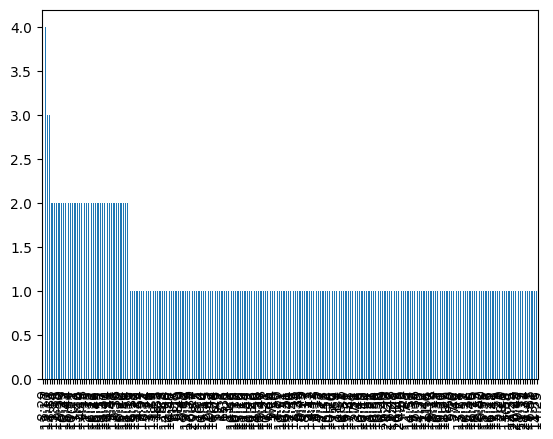

In [43]:
pd.Series(ll).value_counts().plot(kind='bar')

In [44]:
for i in np.where(regr.feature_importances_ > 0):
    print(X_train.columns[i])

Index(['RR0-1', 'RR1-2', 'RR2-3', 'RR3-4', 'RR4-5', 'RR5-6', 'RR6-7', 'RR7-8',
       'RR8-9', 'RR9-10', 'RR10-11', 'RR11-12', 'RR12-13', 'RR13-14',
       'RR14-15', 'RR15-16', 'RR16-17', 'RR17-18', 'RR18-19', 'RR19-20',
       'RR20-21', 'RR21-22', 'RR22-23', 'ER0-1', 'ER1-2', 'ER2-3', 'ER3-4',
       'ER4-5', 'ER5-6', 'ER6-7', 'ER7-8', 'ER8-9', 'ER9-10', 'ER10-11',
       'ER11-12', 'ER12-13', 'ER13-14', 'ER14-15', 'ER15-16', 'ER16-17',
       'ER17-18', 'ER18-19', 'ER19-20', 'ER20-21', 'ER21-22', 'ER22-23',
       'RR-C 0-1', 'RR-C 1-2', 'RR-C 2-3', 'RR-C 3-4', 'RR-C 4-5', 'RR-C 5-6',
       'RR-C 6-7', 'RR-C 7-8', 'RR-C 8-9', 'RR-C 9-10', 'RR-C 10-11',
       'RR-C 11-12', 'RR-C 12-13', 'RR-C 13-14', 'RR-C 14-15', 'RR-C 15-16',
       'RR-C 16-17', 'RR-C 17-18', 'RR-C 18-19', 'RR-C 19-20', 'RR-C 20-21',
       'RR-C 21-22', 'RR-C 22-23', 'RR-C 23-24', 'ER-C 0-1', 'ER-C 1-2',
       'ER-C 2-3', 'ER-C 3-4', 'ER-C 4-5', 'ER-C 5-6', 'ER-C 6-7', 'ER-C 7-8',
       'ER-C 8-9', 'ER-C 9-1

In [46]:
X_train, X_test, y_train, y_test, df_train, df_test = split_train_test_by_lifetime(X, df, data, test_size=0.30, random_seed=42)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [47]:
regr = RandomForestRegressor()
regr.fit(X_train, y_train)

RandomForestRegressor()

In [59]:
X_test_fit = X_test.copy()
X_test_fit.loc[:, 'fitSA'] = 1 # fitSA
X_test_fit.loc[:, 'fitAC'] = 1 # fitAC
preds = regr.predict(X_test_fit)

start_time = time.time()
out = evaluate(df_test, X_test, data, received_hour_range, preds)
print("--- %s seconds ---" % (time.time() - start_time))
print(out)

--- 1.1831634044647217 seconds ---
(0.39712918660287083, 0.2631578947368421, 0.3397129186602871)
